In [1]:
root_data = "/media/diego/QData/datasets/traffic_signs/"
train_data = root_data + "train.p"
valid_data = root_data + "valid.p"
test_data = root_data + "test.p"
results = root_data + "results/"

In [2]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers.merge import Concatenate
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50

from keras.backend import tf as k

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from utils import *
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *
from vgg16 import Vgg16

Using TensorFlow backend.


In [3]:
# Load pickled data
import pickle

with open(train_data, mode='rb') as f:
    train = pickle.load(f)
with open(test_data, mode='rb') as f:
    test = pickle.load(f)
with open(valid_data, mode='rb') as f:
    valid = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [4]:
limit_mem()

In [5]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_valid /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'valid samples')
print(X_test.shape[0], 'test samples')

X_train shape: (34799, 32, 32, 3)
34799 train samples
4410 valid samples
12630 test samples


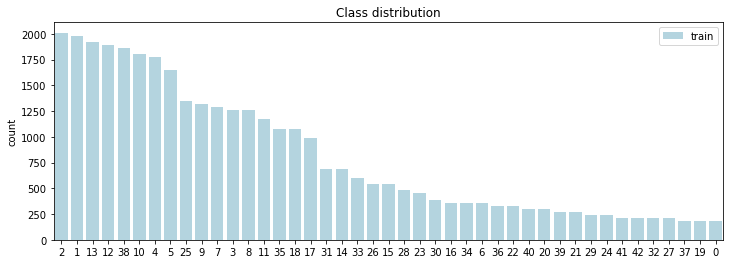

In [6]:
from collections import Counter
train_label_counter = Counter(y_train)

train_counter = Counter(y_train)
order = list(zip(*train_counter.most_common()))[0]

f, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(x=y_train, order=order, color='lightblue', ax=ax, label="train")

_ = ax.set_title('Class distribution')
_ = ax.legend(ncol=2, loc="upper right", frameon=True)

In [7]:
Y_train = np_utils.to_categorical(y_train, 43)
Y_valid = np_utils.to_categorical(y_valid, 43)
Y_test = np_utils.to_categorical(y_test, 43)

print (Y_train.shape)

(34799, 43)


In [7]:
nb_train_samples = X_train.shape[0]
nb_valid_samples = X_valid.shape[0]
batch_size = 32
steps_per_epoch = nb_train_samples // batch_size
valid_steps = nb_valid_samples // batch_size

In [8]:
def relu(x): return Activation('relu')(x)
def dropout(x, p): return Dropout(p)(x) if p else x
def bn(x): return BatchNormalization()(x)
def relu_bn(x): return relu(bn(x))

In [9]:
def conv(x, nf, sz, wd, p):
    x = Conv2D(nf, (sz, sz), kernel_initializer="he_uniform", padding='same', 
                          kernel_regularizer=regularizers.l2(wd))(x)
    return dropout(x,p)

In [10]:
def conv_block(x, nf, bottleneck=False, p=None, wd=0):
    x = relu_bn(x)
    if bottleneck: x = relu_bn(conv(x, nf * 4, 1, wd, p))
    return conv(x, nf, 3, wd, p)

In [11]:
def dense_block(x, nb_layers, growth_rate, bottleneck=False, p=None, wd=0):
    if bottleneck: nb_layers //= 2
    for i in range(nb_layers):
        b = conv_block(x, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        x = merge([x,b], mode='concat', concat_axis=-1)
    return x

In [12]:
def transition_block(x, compression=1.0, p=None, wd=0):
    nf = int(x.get_shape().as_list()[-1] * compression)
    x = relu_bn(x)
    x = conv(x, nf, 1, wd, p)
    return AveragePooling2D((2, 2), strides=(2, 2))(x)

In [13]:
def create_dense_net(nb_classes, img_input, depth=40, nb_block=3, 
     growth_rate=12, nb_filter=16, bottleneck=False, compression=1.0, p=None, wd=0, activation='softmax'):
    
    assert activation == 'softmax' or activation == 'sigmoid'
    assert (depth - 4) % nb_block == 0
    nb_layers_per_block = int((depth - 4) / nb_block)
    nb_layers = [nb_layers_per_block] * nb_block

    x = conv(img_input, nb_filter, 3, wd, 0)
    for i,block in enumerate(nb_layers):
        x = dense_block(x, block, growth_rate, bottleneck=bottleneck, p=p, wd=wd)
        if i != len(nb_layers)-1:
            x = transition_block(x, compression=compression, p=p, wd=wd)

    x = relu_bn(x)
    x = GlobalAveragePooling2D()(x)
    return Dense(nb_classes, activation=activation, kernel_regularizer=regularizers.l2(wd))(x)

In [14]:
input_shape = (32,32,3)

In [15]:
img_input = Input(shape=input_shape)

In [16]:
x = create_dense_net(43, img_input, depth=100, nb_filter=16, compression=0.5, 
                     bottleneck=True, p=0.2, wd=1e-4)

/home/diego/anaconda3/envs/dsretreat/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """
/home/diego/anaconda3/envs/dsretreat/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [17]:
model = Model(img_input, x)

In [18]:
model.compile(loss='sparse_categorical_crossentropy', 
      optimizer=keras.optimizers.SGD(0.1, 0.9, nesterov=True), metrics=["accuracy"])

In [ ]:
K.set_value(model.optimizer.lr, 0.1)
model.fit(X_train, y_train, 64, 20, verbose=1, validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 210s - loss: 2.6717 - acc: 0.3900 - val_loss: 3.0927 - val_acc: 0.4354
Epoch 2/20
34799/34799 [==============================] - 195s - loss: 0.9215 - acc: 0.8911 - val_loss: 1.4083 - val_acc: 0.8039
Epoch 3/20
34799/34799 [==============================] - 192s - loss: 0.6249 - acc: 0.9691 - val_loss: 1.0489 - val_acc: 0.8637
Epoch 4/20
34799/34799 [==============================] - 193s - loss: 0.5086 - acc: 0.9829 - val_loss: 0.8672 - val_acc: 0.8943
Epoch 5/20
34799/34799 [==============================] - 196s - loss: 0.4359 - acc: 0.9861 - val_loss: 0.8004 - val_acc: 0.8959
Epoch 6/20
34799/34799 [==============================] - 191s - loss: 0.3756 - acc: 0.9897 - val_loss: 0.5253 - val_acc: 0.9506
Epoch 7/20
34799/34799 [==============================] - 191s - loss: 0.3302 - acc: 0.9903 - val_loss: 0.4271 - val_acc: 0.9630
Epoch 8/20
34799/34799 [========================

In [ ]:
model.save(results+'first_model.hp5')

In [41]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(X_train, y_train, 64, 4, verbose=1, validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/4
34799/34799 [==============================] - 289s - loss: 0.1276 - acc: 0.9989 - val_loss: 0.1618 - val_acc: 0.9884
Epoch 2/4
34799/34799 [==============================] - 285s - loss: 0.1230 - acc: 0.9995 - val_loss: 0.1585 - val_acc: 0.9878
Epoch 3/4
34799/34799 [==============================] - 288s - loss: 0.1196 - acc: 0.9997 - val_loss: 0.1505 - val_acc: 0.9891
Epoch 4/4
34799/34799 [==============================] - 288s - loss: 0.1164 - acc: 0.9999 - val_loss: 0.1472 - val_acc: 0.9893


In [42]:
K.set_value(model.optimizer.lr, 0.1)
model.fit(X_train, y_train, 64, 20, verbose=1, validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 288s - loss: 0.1389 - acc: 0.9936 - val_loss: 0.4966 - val_acc: 0.9254
Epoch 2/20
34799/34799 [==============================] - 289s - loss: 0.1400 - acc: 0.9935 - val_loss: 0.4093 - val_acc: 0.9392
Epoch 3/20
34799/34799 [==============================] - 289s - loss: 0.1295 - acc: 0.9961 - val_loss: 0.3114 - val_acc: 0.9492
Epoch 4/20
34799/34799 [==============================] - 289s - loss: 0.1285 - acc: 0.9951 - val_loss: 0.2037 - val_acc: 0.9748
Epoch 5/20
34799/34799 [==============================] - 289s - loss: 0.1321 - acc: 0.9941 - val_loss: 0.5978 - val_acc: 0.9132
Epoch 6/20
34799/34799 [==============================] - 290s - loss: 0.1392 - acc: 0.9932 - val_loss: 0.2569 - val_acc: 0.9571
Epoch 7/20
34799/34799 [==============================] - 289s - loss: 0.1291 - acc: 0.9963 - val_loss: 0.5426 - val_acc: 0.9091
Epoch 8/20
34799/34799 [========================

In [43]:
K.set_value(model.optimizer.lr, 0.01)
model.fit(X_train, y_train, 64, 20, verbose=1, validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 289s - loss: 0.1055 - acc: 0.9986 - val_loss: 0.1257 - val_acc: 0.9934
Epoch 2/20
34799/34799 [==============================] - 288s - loss: 0.0995 - acc: 0.9996 - val_loss: 0.1282 - val_acc: 0.9923
Epoch 3/20
34799/34799 [==============================] - 289s - loss: 0.0971 - acc: 0.9998 - val_loss: 0.1201 - val_acc: 0.9948
Epoch 4/20
34799/34799 [==============================] - 288s - loss: 0.0946 - acc: 0.9998 - val_loss: 0.1161 - val_acc: 0.9966
Epoch 5/20
34799/34799 [==============================] - 288s - loss: 0.0922 - acc: 1.0000 - val_loss: 0.1137 - val_acc: 0.9959
Epoch 6/20
34799/34799 [==============================] - 288s - loss: 0.0904 - acc: 1.0000 - val_loss: 0.1136 - val_acc: 0.9941
Epoch 7/20
34799/34799 [==============================] - 288s - loss: 0.0886 - acc: 0.9999 - val_loss: 0.1141 - val_acc: 0.9937
Epoch 8/20
34799/34799 [========================

In [44]:
K.set_value(model.optimizer.lr, 0.001)
model.fit(X_train, y_train, 64, 20, verbose=1, validation_data=(X_valid, y_valid))

Train on 34799 samples, validate on 4410 samples
Epoch 1/20
34799/34799 [==============================] - 287s - loss: 0.0664 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9961
Epoch 2/20
34799/34799 [==============================] - 289s - loss: 0.0661 - acc: 1.0000 - val_loss: 0.0871 - val_acc: 0.9961
Epoch 3/20
34799/34799 [==============================] - 288s - loss: 0.0660 - acc: 0.9999 - val_loss: 0.0866 - val_acc: 0.9961
Epoch 4/20
34799/34799 [==============================] - 288s - loss: 0.0659 - acc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9961
Epoch 5/20
34799/34799 [==============================] - 289s - loss: 0.0657 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9964
Epoch 6/20
34799/34799 [==============================] - 288s - loss: 0.0656 - acc: 1.0000 - val_loss: 0.0860 - val_acc: 0.9964
Epoch 7/20
34799/34799 [==============================] - 288s - loss: 0.0655 - acc: 1.0000 - val_loss: 0.0861 - val_acc: 0.9964
Epoch 8/20
34799/34799 [========================